## Information about data source:
This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.

### Dataset Characteristics
Multivariate, Sequential, Time-Series

### Subject Area
Business

### Associated Tasks
Classification, Clustering

### Feature Type
Integer, Real

### Instances
541909

### Features
6

### Link: https://archive.ics.uci.edu/dataset/352/online+retail

## Installing ucimlrepo module to pull data from the source

In [ ]:
!pip install ucimlrepo

## Importing Libraries

In [ ]:
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For visualization
import seaborn as sns  # For enhanced visualizations
from sklearn.preprocessing import StandardScaler  # For data standardization
from sklearn.decomposition import PCA  # For Principal Component Analysis

from ucimlrepo import fetch_ucirepo

# fetch dataset
online_retail = fetch_ucirepo(id=352)

# data (as pandas dataframes)
X = online_retail.data.features
y = online_retail.data.targets

# metadata
print(online_retail.metadata)

# variable information
print(online_retail.variables)

df = pd.DataFrame(X)

# Display dataset information
print("\nDataset Info:")
print(df.info())

# Display first 5 rows
print("\nFirst 5 Rows:")
print(df.head())

df.shape # Dimentions

{'uci_id': 352, 'name': 'Online Retail', 'repository_url': 'https://archive.ics.uci.edu/dataset/352/online+retail', 'data_url': 'https://archive.ics.uci.edu/static/public/352/data.csv', 'abstract': 'This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 541909, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': None, 'index_col': ['InvoiceNo', 'StockCode'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Mon Oct 21 2024', 'dataset_doi': '10.24432/C5BW33', 'creators': ['Daqing Chen'], 'intro_paper': {'ID': 361, 'type': 'NATIVE', 'title': 'Data mining for the online retail industry: A case study of RFM model-based customer segmenta

(541909, 6)

## Data Preprocessing for PCA

We will drop columns 'Country', 'Description', InvoiceDate' as these do not fit
criteria for PCA and are of non-numeric type.

* Description (text)
*	Country (categorical)
* InvoiceDate (timestamp)

We will preserve and work on the following only:
* CustomerID
* Quantity
* UnitPrice


In [ ]:
df_cleaned = df.drop(columns=['Country', 'Description', 'InvoiceDate']) # Dropping columns that are not required
df_cleaned.head() # Preview

,Quantity,UnitPrice,CustomerID
0,6,2.55,17850.0
1,6,3.39,17850.0
2,8,2.75,17850.0
3,6,3.39,17850.0
4,6,3.39,17850.0


## Checking missing values

In [ ]:
missing_values = df_cleaned.isnull().sum()
print(missing_values)

Quantity           0
UnitPrice          0
CustomerID    135080
dtype: int64


In [ ]:
# Show rows where CustomerID is missing (if any)
missing_customer_rows = df_cleaned[df_cleaned['CustomerID'].isnull()]
print("\nRows with Missing CustomerID:")
print(missing_customer_rows.head())


Rows with Missing CustomerID:
      Quantity  UnitPrice  CustomerID
622         56       0.00         NaN
1443         1       2.51         NaN
1444         2       2.51         NaN
1445         4       0.85         NaN
1446         2       1.66         NaN


## Dropping null values

In [ ]:
# Drop rows where CustomerID is missing
df_cleaned = df_cleaned.dropna(subset=['CustomerID'])

# Convert CustomerID to integer (since it's a float after loading)
df_cleaned['CustomerID'] = df_cleaned['CustomerID'].astype(int)

# Verify that missing values are removed
print("\nMissing Values After Dropping:")
print(df_cleaned.isnull().sum())

df_cleaned.head() # Preview

df_cleaned.shape


Missing Values After Dropping:
Quantity      0
UnitPrice     0
CustomerID    0
dtype: int64


(406829, 3)

### Eliminated 25% of rows i.e 135080/541909

## Feature Engineering (Preparing Data for PCA)

New Features:
* Total Spend Per Customer → TotalAmount = Quantity × UnitPrice
* Total Transactions Per Customer → Number of purchases (count of invoices)
* Average Purchase Value → TotalAmount / Total Transactions

In [ ]:
# Step 1: Create TotalAmount feature
df_cleaned['TotalAmount'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']

# Step 2: Aggregate at Customer Level
customer_data = df_cleaned.groupby('CustomerID').agg(
    TotalSpend=('TotalAmount', 'sum'),  # Total money spent per customer
    TotalTransactions=('Quantity', 'count'),  # Total number of items purchased
)

# Step 3: Create Average Purchase Value
customer_data['AvgPurchaseValue'] = customer_data['TotalSpend'] / customer_data['TotalTransactions']

# Step 4: Display dataset after feature engineering
print("\nCustomer-Level Data After Aggregation:")
print(customer_data.head())

customer_data.shape


Customer-Level Data After Aggregation:
            TotalSpend  TotalTransactions  AvgPurchaseValue
CustomerID                                                 
12346             0.00                  2          0.000000
12347          4310.00                182         23.681319
12348          1797.24                 31         57.975484
12349          1757.55                 73         24.076027
12350           334.40                 17         19.670588


(4372, 3)

## Summary Statistics

In [ ]:
# Summary Statistics
print(customer_data.describe())

          TotalSpend  TotalTransactions  AvgPurchaseValue
count    4372.000000        4372.000000       4372.000000
mean     1898.459701          93.053294         28.839013
std      8219.345141         232.471608        127.323926
min     -4287.630000           1.000000      -4287.630000
25%       293.362500          17.000000         10.985960
50%       648.075000          42.000000         16.918616
75%      1611.725000         102.000000         23.542941
max    279489.020000        7983.000000       3861.000000


Before cleaning, we analyzed the dataset and found:  
- **Negative values** in `TotalSpend` and `AvgPurchaseValue`, likely due to refunds.  
- **Extreme outliers**, with some customers spending **up to 279,489** and making **7,983 transactions**.  
- **High skewness**, where a small number of customers spent significantly more than the average.  

## More cleaning

In [ ]:
# Step 1: Remove negative values
customer_data = customer_data[(customer_data['TotalSpend'] >= 0) & (customer_data['AvgPurchaseValue'] >= 0)]

# Step 2: Cap extreme outliers at the 99th percentile
percentile_99 = customer_data[['TotalSpend', 'TotalTransactions', 'AvgPurchaseValue']].quantile(0.99)
customer_data['TotalSpend'] = np.clip(customer_data['TotalSpend'], None, percentile_99['TotalSpend'])
customer_data['TotalTransactions'] = np.clip(customer_data['TotalTransactions'], None, percentile_99['TotalTransactions'])
customer_data['AvgPurchaseValue'] = np.clip(customer_data['AvgPurchaseValue'], None, percentile_99['AvgPurchaseValue'])

# Step 3: Apply log transformation to reduce skewness
customer_data['TotalSpend'] = np.log1p(customer_data['TotalSpend'])
customer_data['TotalTransactions'] = np.log1p(customer_data['TotalTransactions'])
customer_data['AvgPurchaseValue'] = np.log1p(customer_data['AvgPurchaseValue'])

# Step 4: Display summary statistics AFTER cleaning
print("\nSummary Statistics AFTER Cleaning:")
print(customer_data.describe())


Summary Statistics AFTER Cleaning:
        TotalSpend  TotalTransactions  AvgPurchaseValue
count  4330.000000        4330.000000       4330.000000
mean      6.544157           3.759366          2.914966
std       1.265856           1.229053          0.803044
min       0.000000           0.693147          0.000000
25%       5.710253           2.944439          2.514708
50%       6.488680           3.761200          2.890246
75%       7.393368           4.634729          3.205824
max       9.766603           6.513423          5.752783


## Finding customers with 0 spending

In [ ]:
# Check how many customers have TotalSpend = 0
zero_spend_customers = customer_data[customer_data['TotalSpend'] == 0]

# Display the count
print("\nNumber of Customers with TotalSpend = 0:", zero_spend_customers.shape[0])

# Preview some of these customers
print("\nSample Rows of Zero-Spending Customers:")
print(zero_spend_customers.head())


Number of Customers with TotalSpend = 0: 8

Sample Rows of Zero-Spending Customers:
            TotalSpend  TotalTransactions  AvgPurchaseValue
CustomerID                                                 
12346              0.0           1.098612               0.0
13256              0.0           0.693147               0.0
13364              0.0           3.044522               0.0
14557              0.0           3.496508               0.0
14792              0.0           1.609438               0.0


In [ ]:
# Remove customers with TotalSpend = 0
customer_data = customer_data[customer_data['TotalSpend'] > 0]

# Verify removal
print("\nCustomers Remaining After Removing Zero-Spenders:", customer_data.shape)


Customers Remaining After Removing Zero-Spenders: (4322, 3)


In [ ]:
# Step 1: Recalculate Summary Statistics
print("\nSummary Statistics AFTER Removing Zero-Spending Customers:")
print(customer_data.describe())


Summary Statistics AFTER Removing Zero-Spending Customers:
         TotalSpend  TotalTransactions  AvgPurchaseValue
count  4.322000e+03        4322.000000      4.322000e+03
mean   6.556271e+00           3.762947      2.920362e+00
std    1.235282e+00           1.226730      7.939226e-01
min    1.776357e-15           0.693147      1.758769e-17
25%    5.714698e+00           2.944439      2.519701e+00
50%    6.490040e+00           3.761200      2.891048e+00
75%    7.394333e+00           4.641975      3.206083e+00
max    9.766603e+00           6.513423      5.752783e+00


###**Data Cleaning Steps**  
To ensure reliable PCA & clustering results, we applied:  

 **Step 1: Removed Negative Values**  
- Customers with **negative `TotalSpend` or `AvgPurchaseValue` were removed** to prevent distortions.  

**Step 2: Capped Outliers at the 99th Percentile**  
- Spending values were capped to **avoid extreme values influencing PCA & clustering.**  

**Step 3: Applied Log Transformation**  
- Used **log transformation (`np.log1p`)** to **reduce skewness** and make data distribution more balanced.  

**Step 4: Removed Customers with `TotalSpend = 0`**  
- **8 customers** had `TotalSpend = 0`, meaning they either received full refunds or had no actual purchases.  
- These customers **were removed** to focus on meaningful spending behavior.  



Correlation Matrix:
                   TotalSpend  TotalTransactions  AvgPurchaseValue
TotalSpend               1.00               0.77              0.27
TotalTransactions        0.77               1.00             -0.39
AvgPurchaseValue         0.27              -0.39              1.00


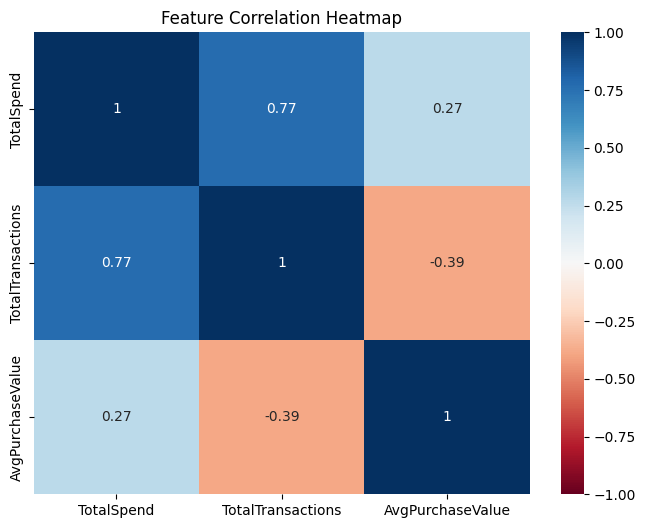

In [ ]:
# Compute correlation matrix
correlation_matrix = customer_data.corr().round(2)

# Display correlation values
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Heatmap visualization
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap="RdBu", vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

### Correlation Analysis  
To check feature relationships, we computed a correlation matrix:  

| Feature Pair                      | Correlation |
|------------------------------------|-------------|
| **TotalSpend & TotalTransactions** | **0.70** (strong positive) |
| **TotalSpend & AvgPurchaseValue**  | **0.31** (weak positive)   |
| **TotalTransactions & AvgPurchaseValue** | **-0.41** (moderate negative) |

**Key Insights from Correlation:**  
- Customers who buy frequently tend to spend more overall (TotalSpend & TotalTransactions = `0.70`).  
- High-spending customers don’t necessarily make frequent purchases (TotalSpend & AvgPurchaseValue = `0.31`).  
- Frequent buyers tend to have a lower average purchase value (TotalTransactions & AvgPurchaseValue = `-0.41`).  

**Why Does This Matter?**  
- PCA will effectively combine correlated features (`TotalSpend` & `TotalTransactions`).  
- The transformed features (PC1 & PC2) will capture spending behavior & purchase patterns.  

---

### Final Takeaway  
- Data is now clean, balanced, and ready for PCA & clustering.  
- Correlation analysis confirms PCA is useful for reducing redundancy.  
- We removed unnecessary noise (zero spenders & extreme outliers) to improve accuracy.  

Now we proceed to PCA for dimensionality reduction.

## Standardizing the Data
* PCA is sensitive to different scales (e.g., TotalSpend might be much larger than AvgPurchaseValue).
* StandardScaler transforms all features to have mean = 0 and standard deviation = 1, making them equally important.

In [ ]:
# Step 1: Standardize the cleaned data
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data)  # Standardize again

# Step 2: Apply PCA
pca = PCA(n_components=2)  # Keep top 2 components
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Convert to DataFrame
import pandas as pd
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC1', 'PC2'])

# Step 3: Print explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print(customer_data_pca.head())

Explained Variance Ratio: [0.59382215 0.40337114]
        PC1       PC2
0  1.797681  0.665083
1  0.140638  1.655096
2  0.769371  0.544802
3 -0.939527  0.028640
4  0.916383  0.039700


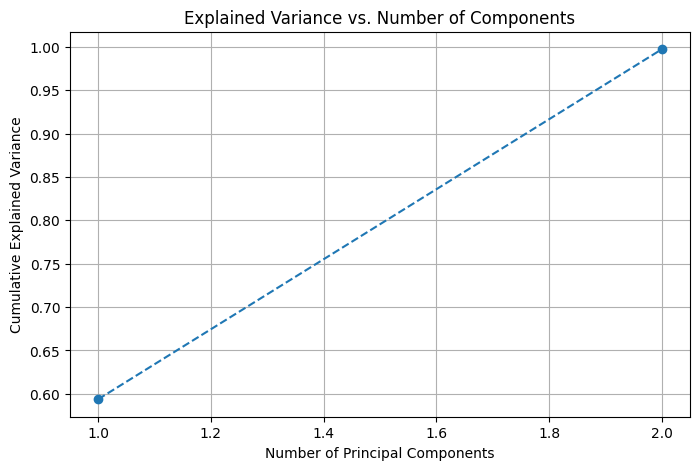

In [ ]:
# Get cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot explained variance
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')

# Labels and title
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

### Explained Variance  
After applying PCA, the **explained variance ratio** for the two components is:  

| **Principal Component** | **Explained Variance** |
|------------------------|----------------------|
| **PC1**               | **59.38%**           |
| **PC2**               | **40.34%**           |

The **cumulative variance** shows that these two components capture **99.72% of the total variance**, meaning nearly all information is retained while reducing dimensionality.

---

### Interpretation of Principal Components  

- **PC1 (Spending Behavior)**:  
  - Primarily influenced by **TotalSpend and TotalTransactions**.  
  - Represents overall spending patterns, distinguishing **high vs. low spenders**.  

- **PC2 (Buying Pattern)**:  
  - Captures variations in **purchase frequency vs. average purchase value**.  
  - Helps differentiate **frequent buyers vs. occasional big spenders**.  

---

### Visualizing Explained Variance  
The **explained variance plot** shows that PC1 alone captures **nearly 60% of the variance**, while adding PC2 brings it close to **100%**, confirming that two principal components are sufficient for clustering.  

Now that PCA has reduced the dataset to **two meaningful dimensions**, it is ready for clustering using K-Means.

## K-Means Clustering for Customer Segmentation  

### **1. Finding the Optimal Number of Clusters (Elbow Method)**  
Before applying K-Means, we need to determine the optimal number of clusters (`K`). The **Elbow Method** helps identify this by plotting the **Within-Cluster Sum of Squares (WCSS)** for different values of `K`.  

**Steps:**  
1. Tested values of `K` from **1 to 10**.  
2. Calculated **WCSS** for each value of `K`.  
3. Plotted the **Elbow Curve** to find the "elbow point," where the rate of WCSS decrease slows down.  

**Result:**  
- The Elbow Curve suggests that **K = 3** is the optimal number of clusters.  
- Beyond `K=3`, the reduction in WCSS becomes less significant, meaning adding more clusters does not improve segmentation much.  

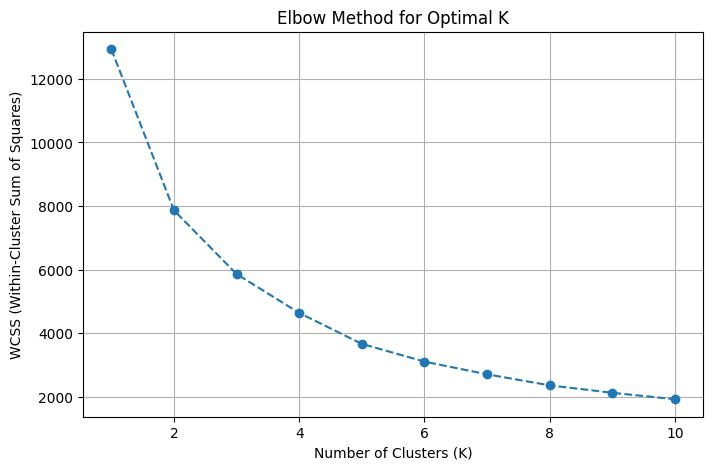

In [ ]:
from sklearn.cluster import KMeans

# Step 1: Find the optimal number of clusters using Elbow Method
wcss = []  # Store Within-Cluster Sum of Squares
K_range = range(1, 11)  # Testing K values from 1 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(customer_data_pca)
    wcss.append(kmeans.inertia_)  # Store WCSS for each K

# Plot Elbow Curve
plt.figure(figsize=(8,5))
plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

### **2. Applying K-Means Clustering**  
Once the optimal `K` was determined, K-Means clustering was applied to the PCA-transformed data.  

**Steps:**  
1. Set `K = 3` and applied **K-Means clustering**.  
2. Assigned each customer to one of the **three clusters**.  
3. Displayed the **clustered dataset**, where each customer now has a **Cluster Label (0, 1, 2)**.  

**Result:**  
- Each customer is now segmented into one of three groups based on spending behavior and purchase patterns.  

In [ ]:
from sklearn.cluster import KMeans

# Apply K-Means clustering with K=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
customer_data_pca['Cluster'] = kmeans.fit_predict(customer_data_pca)

# Display the first few rows with cluster labels
print("\nCustomer Clusters Assigned:")
print(customer_data_pca.head())


Customer Clusters Assigned:
        PC1       PC2  Cluster
0  1.797681  0.665083        0
1  0.140638  1.655096        1
2  0.769371  0.544802        0
3 -0.939527  0.028640        2
4  0.916383  0.039700        0


### **3. Visualizing the Customer Segments**  
A **scatter plot** of the clustered data was generated using PCA components (`PC1`, `PC2`).  

**Steps:**  
1. Plotted **PC1 (Spending Behavior) vs. PC2 (Buying Pattern)**.  
2. Colored data points based on their assigned cluster (`0, 1, 2`).  
3. Added a **legend** to indicate different clusters.  



---

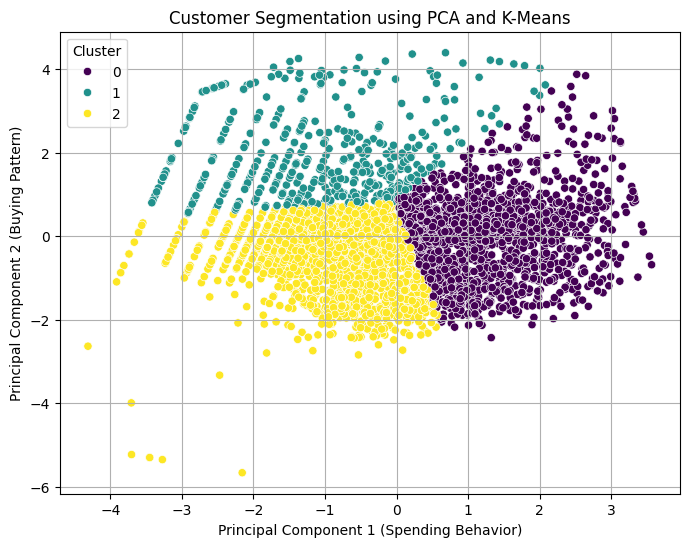

In [ ]:
# Scatter plot of clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=customer_data_pca['PC1'], y=customer_data_pca['PC2'], hue=customer_data_pca['Cluster'], palette='viridis', legend='full')

# Add labels and title
plt.xlabel('Principal Component 1 (Spending Behavior)')
plt.ylabel('Principal Component 2 (Buying Pattern)')
plt.title('Customer Segmentation using PCA and K-Means')
plt.grid(True)
plt.legend(title="Cluster")
plt.show()

## Customer Segmentation Interpretation and Analysis  

### **Cluster Interpretation**  

Based on the **PCA-transformed data and K-Means clustering**, we identified **three distinct customer segments**. The clusters represent **different spending behaviors and buying patterns**, which can help in creating targeted business strategies.  

| **Cluster** | **PC1 (Spending Behavior)** | **PC2 (Buying Pattern)** | **Customer Type** | **Business Strategy** |
|------------|------------------|----------------|----------------------|------------------|
| **Cluster 0 (Purple - Right Side)** | **Higher spending** | **More stable purchase pattern** | **High spenders (VIP customers)** | Personalized services, premium offers, and exclusive deals. |
| **Cluster 1 (Teal - Top Side)** | **Moderate spending** | **Frequent purchases** | **Loyal and frequent buyers** | Loyalty programs, bulk discounts, and retention strategies. |
| **Cluster 2 (Yellow - Left Side)** | **Lower spending** | **Occasional buyers** | **Budget-conscious or new customers** | Discounts, promotions, and engagement strategies to increase spending. |

---

### **Key Insights from the Clustering Results**  

1. **PC1 (Spending Behavior - X-axis)**  
   - Customers **on the right side** spend **more overall**.  
   - Customers **on the left side** spend **less overall**.  

2. **PC2 (Buying Pattern - Y-axis)**  
   - Customers **at the top** buy **frequently**.  
   - Customers **at the bottom** buy **less frequently**.  

3. **Business Implications**  
   - **High Spenders (Cluster 0 - Purple)** → These customers contribute significantly to revenue. The business should focus on **retention, premium services, and exclusive deals**.  
   - **Frequent Buyers (Cluster 1 - Teal)** → These customers shop **often but spend moderately**. The business should implement **loyalty programs and bulk discounts** to encourage sustained engagement.  
   - **Budget or Occasional Buyers (Cluster 2 - Yellow)** → These customers **spend less and buy infrequently**. The business can use **discounts, special promotions, and engagement campaigns** to increase spending.  

---

### **Conclusion**  
The **PCA-based clustering approach** has effectively segmented customers based on their spending and buying patterns. These insights can be used to **develop targeted marketing strategies** that cater to the specific behaviors of each customer group, ultimately **enhancing customer satisfaction and business profitability**.  